# Lecture XI

Modelling and Machine Learning of Dynamical Systems in Julia

Neural Differential Equations or Universal Differential Equations 

## Recap Last Lecture: ANNs 

* Last lecture, we introduced artificial neural networks (ANNs), in the form of multilayer perceptrons (MLPs)

* Networks made up of a chain of several layers: $$f(\mathbf x) = f^{(3)}(f^{(2)}(f^{(1)}(\mathbf x))),$$ where each layers is a nonlinear transformation: $$\sigma(\mathbf z^{\mathrm T} \mathbf W + \mathbf b),$$ where $\theta=\{\mathbf{W},\mathbf{b}\}$ are the learnable parameters and $\sigma$ is a nonlinear activation function, such as $\tanh$
* They are *universal function approximators* with many parameters $\theta$
* Given training data, we seek the best set of parameters by minimzing a loss function $L(\theta)$, e.g. a mean square error, on that training data, by means of a gradient descent optimization, for which we need $$\nabla_\theta L(\mathbf \theta).$$ 
* The gradients are computed via *backpropagation*, i.e. chain rule of derivatives
* ML libaries compute this via an automatic differenation system, that is able to systematically track all elementary operations performed
* In Julia, `Flux.jl` is the most commonly used library for ANNs 
    * Last week, in the lecture, the notes mostly referred to Flux' old syntax
    * `Flux.jl` changes parts of its syntax / internals
    * Currently both the old and new variant is usable
    * Today we will only use the new variant 


## Today's Topic: Neural Differential Equations

* Based on 
    * [Chen et al, 2018: Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366)
    * [Rackauckas et al, 2020: Universal Differential Equations for Scientific Machine Learning](https://arxiv.org/abs/2001.04385) / `DiffEqFlux.jl`
    * (and a bit on) [Gelbrecht et al, 2021: Neural partial differential equations for chaotic systems](https://iopscience.iop.org/article/10.1088/1367-2630/abeb90)

### Different Types of ANNs 

* Aside from MLPs, there are many different types of ANNs, e.g:![image-2.png](assets/typesofanns.png)


### Neural Differential Equations

* With Neural Differential Equations we try to find a way to combine knowledge that we have of systems in form of their governing equations with data-driven approximators such as ANNs

* In fact, there is an analogy between differential equations and ANNs:

* A Residual Network (ResNet) block is defined by $$\mathbf{h}_{t+1} = \mathbf{h}_t + f(\mathbf{h}_t;\theta_t),$$ where $f$ can be any combination of other neural network layers with parameters $\theta_t$

* Through their short cut connection (see the image), ResNets learn a residual (hence the name). They proved to be an effective architecture for a wide variety of problems

* Compare that to the Euler solver that we learned about in the beginning of the course, to discretize an ODE: 
$$\begin{align}  
\frac{d\mathbf{h}(t)}{dt} &= f(\mathbf{h}(t),t;\theta)\\
\mathbf{h}_{t+1} &= \Delta t f(\mathbf{h}_t, t;\theta) + \mathbf{h}_t\\
\end{align}$$

* Differential equations can be seen as a continuous time limit of ResNet ANNs
* There are several paper that use to just solve ResNets with ODE solvers, but this is not our primary interest

### The Universal Differential Equations Framework

* If we can treat differential equations and ANNs so similar, we not just combine them directly:

$$\frac{du}{dt} = f(u,t,U_\theta(u,t)),$$ 
where $U_{\theta}$ is some data-driven function approximator (such as an ANN)
  
![image-2.png](assets/overview2.png)

* We can integrate these Neural Differential Equations numerically, like any other differential equation we've seen before, resulting in a trajectory $$\hat{\mathbf{u}}(\mathbf{x},t;\theta)$$

* `DiffEqFlux.jl` is by far the most comprehensive implementation of this approach (of all programming languages)
* `torchdiffeq` offers some of the functionality for pyTorch


### How to Train Neural Differential Equations 

* Remember, to train an ANN we usually set a loss function $L(\theta)$ and then minimize this loss on a training data set by doing a gradient descent 

* Given some example trajectories $\mathbf{u}$ as training data, we can define a loss function $$L(\theta)= \sum_{i_t,\mathbf{x}} ( u(\mathbf{x},i_t) - \hat{\mathbf{u}}(\mathbf{x},t;\theta) )^2  + \gamma\sum_i||\theta_i||$$

* The loss function is a sum of the squared differences with an added regularization 

* What do we still need to train? 

* For regular ANNs, we would do a gradient descent by computing $\nabla_\theta L$, but here we have a slightly different situation

* Here $\hat{\mathbf{u}}(\mathbf{x},t;\theta)$ are trajectories, solutions of differential equations 

* How do we take a derivative of solutions of differential equations? 

### Adjoint Sensitivity Problems 

* These kind of problems were already solved before, e.g. by Lev Pontryagin in the 60s, analysing trajectories of rockets, or later in meteorolgy to explore the sensitivity of some climate models 

* There are many different (but vaguely similar) approaches, in Julia `DiffEqSensitivity.jl` implements many of them 

* Here, we outline the approach from [Chen et al](https://arxiv.org/abs/1806.07366): *Reverse-mode adjoint sensitivity analysis*

* Given is an ODE $\dot{\mathbf{x}} = f(\mathbf{x},t;\theta)$ that is integrated from $t_0$ to $t_1$ with parameters $\theta$ and a scalar loss function $L(\mathbf{x}(t_1))$ of the ODE solution that is supposed to be minimized by the training procedure 
* The parameters $\theta$ can include those of data-driven models like ANN
* To compute the gradient $$\frac{\partial\mathcal{L}}{\partial\theta},$$ the ODE is appended with the adjoint
$$\begin{align}
    \mathbf{a}(t) = \frac{\partial \mathcal{L}}{\partial \mathbf{x}(t)}.
\end{align}$$
* The adjoint follows the dynamics
$$\begin{align}
    \frac{d \mathbf{a}}{d t} = - \mathbf{a}^T(t) \frac{\partial f(\mathbf{x}(t),t,\theta)}{\partial \mathbf{x}(t)}
\end{align}$$
and tracks how the gradient of the loss depends on the trajectory. This is needed to compute the desired $\frac{\partial\mathcal{L}}{\partial\theta}$ with another adjoint
\begin{align}
    \mathbf{a}_\theta &= \frac{\partial\mathcal{L}}{\partial\theta(t)} \\
    \frac{d \mathbf{a}_\theta}{d t}& = - \mathbf{a}^T(t) \frac{\partial f(\mathbf{x}(t),t,\theta)}{\partial \theta}
\end{align}

#### Proof
The proof of these dynamics can be seen as a continuous backpropagation. Similar to the traditional, discrete backprogation the chain rule is applied with
\begin{align}
 \frac{d\mathcal{L}}{d\mathbf{x}(t)}&=\frac{d\mathcal{L}}{d\mathbf{x}(t+\epsilon)}\frac{d\mathbf{x}(t+\epsilon)}{d \mathbf{x}(t)}\label{eq:cont-L}
\end{align}
by inserting a state of the trajectory evolved by an incremental time step $\epsilon$. Evolving the trajectory can be approximated with 
\begin{align}
     \mathbf{x}(t+\epsilon) &= \int_t^{t+\epsilon} f(\mathbf{x}(t),t;\theta)dt + \mathbf{x}(t) = T_\epsilon(\mathbf{x}(t),t;\theta) \overset{\epsilon\rightarrow 0}{\approx} \epsilon f(\mathbf{x}(t),t;\theta) + \mathbf{x}(t)
\end{align}
to rewrite the chain rule equation above as 
\begin{align}
\mathbf{a}(t)&=\mathbf{a}(t+\epsilon)\frac{\partial T_\epsilon(\mathbf{x}(t),t)}{\partial \mathbf{x}(t)}.
\end{align}
These results can be used to get the dynamics of $\mathbf{a}(t)$ by inserting them into the definition of its derivative:  
\begin{align}
      \frac{d\mathbf{a}(t)}{dt} &= \lim_{\epsilon\rightarrow 0} \frac{1}{\epsilon}(\mathbf{a}(t+\epsilon) - \mathbf{a}(t)) \\
    &= \lim_{\epsilon\rightarrow 0} \frac{1}{\epsilon}(\mathbf{a}(t+\epsilon) - \mathbf{a}(t+\epsilon)\frac{\partial}{\partial\mathbf{x}(t)}(\mathbf{x}(t)+\epsilon f(\mathbf{x}(t),t;\theta))\\
    &= \lim_{\epsilon\rightarrow 0} - \mathbf{a}(t+\epsilon)\frac{\partial f(\mathbf{x}(t),t;\theta)}{\partial\mathbf{x}(t)}=- \mathbf{a}(t) \frac{\partial f(\mathbf{x}(t),t,\theta)}{\partial \mathbf{x}(t)} .
\end{align}
The dynamics of $\mathbf{a}_\theta$ can be derived analogously. 


#### Reverse-mode Adjoint Sensitivity Problem 

Similar to how a traditional backpropagation traverses the chain of the ANN from the output back to the input, the appended ODE with the adjoints needs to be solved backwards in time as the initial values of the augmented dynamics are only known at the end point of the integration $t_1$. To compute $\frac{\partial\mathcal{L}}{\partial\theta}$, we thus need to solve the appended ODE
\begin{align} 
    \begin{pmatrix}
        \frac{d \mathbf{x}}{d t}\\
        \frac{d \mathbf{a}}{d t}\\ 
        \frac{d \mathbf{a}_\theta}{d t}\\
    \end{pmatrix} =
     \begin{pmatrix}
        f(\mathbf{x},t,\theta)\\
        - \mathbf{a}^T(t) \frac{\partial f(\mathbf{x}(t),t,\theta)}{\partial \mathbf{x}(t)} \\ 
        - \mathbf{a}^T(t) \frac{\partial f(\mathbf{x}(t),t,\theta)}{\partial \theta}\label{eq:node-train}
    \end{pmatrix} 
\end{align}
backwards in time from $t_1$ to $t_0$ with initial conditions $[\mathbf{x}(t_1); \frac{\partial\mathcal{L}}{\partial\mathbf{x}(t_1)}; \mathbf{0}]$ to eventually get $\frac{\partial\mathcal{L}}{\partial\theta} = \mathbf{a}_\theta(t_0)$. The partial derivatives are computed using AD. 



## Neural Differential Equations in Action 

* Now we have (almost) everything! 
    * We know that we can integrate ANNs into differential equations
    * We know how to solve differential equations  
    * We know how to (efficiently) take derivatives of solutions of these solutions 

* In Julia, we have the amazing `DiffEqFlux.jl` and `DiffEqSensitivity.jl` library that implements different sensitivity algorithms and work together with libraries like `Flux.jl` or `Lux.jl`


    
### Training NDEs

* We still have the freedom to choose how exactly we integrate the Neural Differential Equation (NDEs), espacially for which time steps 

* Our [previous studies](https://iopscience.iop.org/article/10.1088/1367-2630/abeb90) showed that it is best to use shorter slices of the trajectory and only integrate the Neural Differential Equation for short time intervals while training initially

* We can increase the time interval later during training 

* Predictions are then made on long time intervals 

* There's the non-registered [NODEData.jl](https://github.com/maximilian-gelbrecht/NODEData.jl.git) that helps with splitting ODE solutions into small batches 

### Example 1: Lotka-Volterra 

* In the first example, we will generate data from a Lotka-Volterra predator-prey system and then show how a neural differential equation can fit this data and predict the system 

* First, we generate the training data, we save the data at a constant step size `dt`

In [30]:
import Pkg
Pkg.activate(;temp=true)
Pkg.add(["OrdinaryDiffEq","Plots","Flux","Optimisers","SciMLSensitivity","Parameters","Distributions"])
Pkg.add(url="https://github.com/maximilian-gelbrecht/NODEData.jl.git")

  Activating new project at `/var/folders/vh/kv_4zdr96jz7s12j89cjcl780000gn/T/jl_moXnoe`
   Resolving package versions...
    Updating `/private/var/folders/vh/kv_4zdr96jz7s12j89cjcl780000gn/T/jl_moXnoe/Project.toml`
  [31c24e10] + Distributions v0.25.107
  [587475ba] + Flux v0.14.9
  [3bd65402] + Optimisers v0.3.1
⌅ [1dea7af3] + OrdinaryDiffEq v6.66.0
  [d96e819e] + Parameters v0.12.3
  [91a5bcdd] + Plots v1.39.0
⌅ [1ed8b502] + SciMLSensitivity v7.51.0
    Updating `/private/var/folders/vh/kv_4zdr96jz7s12j89cjcl780000gn/T/jl_moXnoe/Manifest.toml`
  [47edcb42] + ADTypes v0.2.6
  [621f4979] + AbstractFFTs v1.5.0
⌅ [79e6a3ab] + Adapt v3.7.2
  [dce04be8] + ArgCheck v2.3.0
  [ec485272] + ArnoldiMethod v0.2.0
  [4fba245c] + ArrayInterface v7.7.0
  [4c555306] + ArrayLayouts v1.5.2
  [a9b6321e] + Atomix v0.1.0
  [198e06fe] + BangBang v0.3.39
  [9718e550] + Baselet v0.1.1
  [d1d4a3ce] + BitFlags v0.1.8
  [62783981] + BitTwiddlingConvenienceFunctions v0.1.5
  [fa961155] + CEnum v0.5.0
  [2a0fbf

In [2]:
using OrdinaryDiffEq, NODEData, Plots

function lotka_volterra(x,p,t)
        α, β, γ, δ = p 
        [α*x[1] - β*x[1]*x[2], -γ*x[2] + δ*x[1]*x[2]]
end
    
α = 1.3
β = 0.9
γ = 0.8
δ = 1.8
p = Float32.([α, β, γ, δ])
tspan = (0f0,50f0) # we watch out to really have everything as Float32
dt = 0.1f0

x0 = Float32.([0.44249296, 4.6280594]) 
    
prob = ODEProblem(lotka_volterra, x0, tspan, p) 
sol = solve(prob, Tsit5(), saveat=dt)

train, valid = NODEDataloader(sol, 10; dt=dt, valid_set=0.8)

[ Info: Precompiling NODEData [56c15bac-5c7d-45b6-b0e6-74117a5d8120]
[ Info: Precompiling LinearSolveCUDAExt [e24d4dde-ed20-5ee7-b465-f1dd73f9b6ba]
[ Info: Precompiling SpecialFunctionsExt [1285c0f1-ff9f-5867-b66e-0f359bcf09ba]


(NODEData{Matrix{Float32},Int64} with 92 batches with length 10, NODEData{Matrix{Float32},Int64} with 391 batches with length 10)

* With this we solve the LV system for one long trajectory
* We split the data into a training and validation set 
* The Dataloader also splits it into smaller slices each of length `10` and returns pairs $(t, x(t))$ of this length

In [3]:
train

NODEData{Matrix{Float32},Int64} with 92 batches with length 10

In [4]:
train[4][1]

10-element Vector{Float32}:
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0
 1.1
 1.2

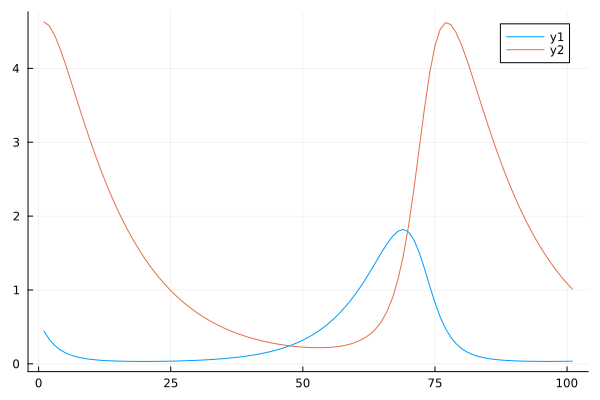

In [5]:
plot(train.data')

* Then, we use `Flux` to define a neural network that will be the right hand side of our Neural Differential Equation
* For this approach, we need to use `Optimisers.destructure` to seperate the structure of the network from its parameters 

In [6]:
using Flux, Optimisers, SciMLSensitivity, Parameters
N_WEIGHTS = 10 
nn = Chain(Dense(2, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, 2)) |> gpu
p, re_nn = Optimisers.destructure(nn)

[ Info: Precompiling ChainRulesCoreExt [eae2faf6-b232-58cb-a410-7764fda2830c]
[ Info: Precompiling NNlibCUDAExt [8a688d86-d2bc-5ad3-8ed1-384f9f2c8cc5]
[ Info: Precompiling BangBangDataFramesExt [d787bcad-b5c5-56bb-adaa-6bfddb178a59]
[ Info: Precompiling TransducersDataFramesExt [cefb4096-3352-5e5f-8501-71f024082a88]
[ Info: Precompiling FluxCUDAExt [dd41ee52-2073-581e-92e8-26baf003f19a]
┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt ~/.julia/packages/Flux/UsEXa/ext/FluxCUDAExt/FluxCUDAExt.jl:56
┌ Info: The CUDA function is being called but CUDA.jl is not functional.
└ Defaulting back to the CPU. (No action is required if you want to run on the CPU).


(Float32[-0.03388438, 0.3890392, 0.3425754, 0.19182152, -0.4412008, -0.22747101, 0.31216872, 0.026454987, 0.1741393, 0.56901145  …  -0.29763633, 0.4216236, 0.3503369, 0.02860515, 0.074181065, -0.59116197, 0.25076842, -0.11431751, 0.0, 0.0], Restructure(Chain, ..., 272))

* `p` are all parameters of the network 
* `re_nn(p)` sets up the network again with `p` as its parameters 

For our first example we will just have the neural network as the rhs, which we set up like most other differential equations: 

In [7]:
neural_ode(u, p, t) = re_nn(p)(u)

node_prob = ODEProblem(neural_ode, x0, (Float32(0.),Float32(dt)), p)

ODEProblem with uType Vector{Float32} and tType Float32. In-place: false
timespan: (0.0f0, 0.1f0)
u0: 2-element Vector{Float32}:
 0.44249296
 4.6280594

We then, define our model that directly returns us a trajectory given a sample for our training set

* It saves the `ODEProblem` and the current parameter values `p`
* It has to save the trajectory at the same time steps and update the parameters and initial conditions to the current state when called
* We also save the `sensealg` that is used in the sensitivity analysis to compute the derivative and potential additional keyword arguments for the solver `kwargs`

We make `Flux.jl`/`Optimisers.jl` aware of the trainable parameters with the `trainable` function.

In [8]:
abstract type AbstractChaoticNDEModel end 

"""
    ChaoticNDE{P,R,A,K} <: AbstractChaoticNDEModel

Model for setting up and training Chaotic Neural Differential Equations.

# Fields:

* `p` parameter vector 
* `prob` DEProblem 
* `alg` Algorithm to use for the `solve` command 
* `kwargs` any additional keyword arguments that should be handed over (e.g. `sensealg`)

# Constructor 

`ChaoticNDE(prob; alg=Tsit5(), kwargs...)`
"""
struct ChaoticNDE{P,R,A,K} <: AbstractChaoticNDEModel
    p::P 
    prob::R 
    alg::A
    kwargs::K
end 

function ChaoticNDE(prob; alg=Tsit5(), kwargs...)
    p = prob.p 
    ChaoticNDE{typeof(p), typeof(prob), typeof(alg), typeof(kwargs)}(p, prob, alg, kwargs)
end 

Flux.@functor ChaoticNDE
Optimisers.trainable(m::ChaoticNDE) = (p=m.p,)

function (m::ChaoticNDE)(X,p=m.p)
    (t, x) = X 
    Array(solve(remake(m.prob; tspan=(t[1],t[end]),u0=x[:,1],p=p), m.alg; saveat=t, m.kwargs...))
end

model = ChaoticNDE(node_prob)
model(train[1])

2×10 Matrix{Float32}:
 0.442493  0.488194  0.534504  0.581424  …  0.775263  0.825272  0.875902
 4.62806   4.62854   4.62887   4.62905      4.62796   4.62719   4.62618

We can then, also define a loss function, which is just a sum of least squares: 

In [9]:
loss(m, x, y) = Flux.mse(m(x),y) 
loss(model, train[1], train[1][2]) 

0.5645832f0

We could take gradients of these manually, and then do some kind of gradient descent manually. Executing a gradient call for the first time takes a while as all the gradient/adjoint code has to be computed and compiled!

In [10]:
g = gradient(model) do m
    loss(m, train[1], train[1][2])
end   

((p = Float32[4.2631644f-5, -0.023484552, -0.0136935245, 0.042963646, -0.0008079957, -0.0009652782, 0.04651663, -0.023354396, 0.00024469238, 0.0044208854  …  -0.06873102, -0.11469818, 0.3059433, 0.5101716, -0.016713593, -0.028274693, -0.011857457, -0.019944577, 0.2916164, 0.48541963], prob = nothing, alg = nothing, kwargs = nothing),)

The `do` syntax is an alternative to writing it with an anonymous function with the inputs `x` and `y` like this:

In [11]:
gradient(m -> loss(m, train[1],train[1][2]), model)

((p = Float32[4.2631644f-5, -0.023484552, -0.0136935245, 0.042963646, -0.0008079957, -0.0009652782, 0.04651663, -0.023354396, 0.00024469238, 0.0044208854  …  -0.06873102, -0.11469818, 0.3059433, 0.5101716, -0.016713593, -0.028274693, -0.011857457, -0.019944577, 0.2916164, 0.48541963], prob = nothing, alg = nothing, kwargs = nothing),)

Both of these calls return for `gradient(f,x,y)` the gradients $\frac{\partial L}{\partial \theta}$ as a named tuple. We can get the gradient with respect to the parameters via 

In [12]:
g[1][:p]

272-element Vector{Float32}:
  4.2631644f-5
 -0.023484552
 -0.0136935245
  0.042963646
 -0.0008079957
 -0.0009652782
  0.04651663
 -0.023354396
  0.00024469238
  0.0044208854
  0.00038057409
 -0.17479835
 -0.101903886
  ⋮
  0.23077932
  0.38612714
 -0.06873102
 -0.11469818
  0.3059433
  0.5101716
 -0.016713593
 -0.028274693
 -0.011857457
 -0.019944577
  0.2916164
  0.48541963

And use this gradient too manually `update!` our parameters. Instead of manually handling the gradients and optimiziation, we'll however rely on predefined functions from `Flux.jl` for that

For the optimiziation we will use an Adam optimizer from `Flux.jl`, which is a form of a stochastic gradient descent. 

In [13]:
η = 1f-3
opt = Optimisers.Adam(η)
opt_state = Optimisers.setup(opt, model)

(p = Leaf(Adam(0.001, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), prob = (), alg = (), kwargs = ())

In [20]:
typeof(train[1])

Tuple{Vector{Float32}, Matrix{Float32}}

In [21]:
loss(model, train[1], train[1][2])

0.5645832f0

Then, we can train the model over a number of epochs, decreasing the learning rate every 30 epochs. We will not do this here, instead I will run a very similar version of this [script](https://github.com/maximilian-gelbrecht/ChaoticNDETools.jl/blob/main/scripts/lv.jl) for you in VSCode, that also plots the training progress. 

In [22]:
TRAIN = true

if TRAIN 
    println("starting training...")

    for i_e = 1:300 
        Flux.train!(model, train, opt_state) do m, t, x 
            loss(m, (t,x), x)
        end

        if (i_e % 30) == 0  # reduce the learning rate every 30 epochs
            η /= 2
            Optimisers.adjust!(opt_state, η)
        end
    end 
    println("... and finished.")
end        

starting training...


### Example 2: Hybrid Models and the Kuramoto-Sivashinsky Equation

* In the first example the neural network was just the complete rhs of the ODE
* However, the main appeal of neural differential equations is that we can also combine analytic terms with ANNs
* In this we can combine a knowledge-based model with a data-driven model 
* This can be e.g. used to attentuate deficiencies and biases of models or model unresolved influences 
* We will demonstrate this by generating data from a known system and then "forget" a part of the equation and show that we can still forcast the complete system, even if only know about a part of it

#### Kuramoto-Sivashinsky Equation

* A full directly executable (also GPU compatible) version of this script is [here](https://github.com/maximilian-gelbrecht/ChaoticNDETools.jl/blob/main/scripts/ks.jl)
* Our example system is the Kuramoto-Sivashinsky equation, another prototypical PDE: $$\frac{\partial u}{\partial t} = -\frac{\partial^4 u}{\partial x^4} - \frac{\partial^2 u}{\partial x^2} + u\cdot\frac{\partial u}{\partial x}$$  
* We first solve the system (via finite differences) and set up the training data

In [23]:
using LinearAlgebra, SparseArrays

"""
    ∂x_PBC(n::Integer, dx::T)

2nd order central finite difference matrix for 1d domains with periodic boundary conditions
"""
function ∂x_PBC(n::Integer, dx::T) where T
    ∂x = (diagm(1=>ones(T, n-1)) + diagm(-1=>-1*ones(T, n-1)))
    ∂x[1,end] = T(-1)
    ∂x[end,1] = T(1)
    ∂x ./= (2*dx)
    return sparse(∂x)
end

"""
    ∂x²_PBC(n::Integer, dx::T)

2nd order central finite difference matrix of the second derivative for 1d domains with periodic boundary conditions
"""
function ∂x²_PBC(n::Integer, dx::T) where T
    ∂x² = diagm(0=>-2*ones(T, n)) + diagm(-1=>ones(T, n-1)) + diagm(1=>ones(T, n-1))
    ∂x²[1,end] = 1
    ∂x²[end,1] = 1
    ∂x² ./= (dx)^2
    return sparse(∂x²)
end

"""
    ∂x⁴_PBC(n::Integer, dx::T)

4th derivative finite difference matrix with periodic boundary conditions
"""
function ∂x⁴_PBC(n::Integer, dx::T) where T
    ∂x² = ∂x²_PBC(n, dx)
    return sparse(∂x² * ∂x²)
end


∂x⁴_PBC

In [24]:
n = 128 # number of grid points
L = 36 # domain size 

# generate KS data and construct the FD Operators
∂x = ∂x_PBC(n, Float32(L/(n-1)))
∂x² = ∂x²_PBC(n, Float32(L/(n-1)))
∂x⁴ = ∂x⁴_PBC(n, Float32(L/(n-1)))
u0 = 0.01f0*(rand(Float32, n) .- 0.5f0)

function ks!(du,u,p,t)
    du .= -∂x⁴*u - ∂x²*u - u.*(∂x*u)
end

t_transient = 200.
N_t = 1000
tspan = (0f0, Float32(t_transient + N_t * dt))

prob = ODEProblem(ks!, u0, tspan)
sol = solve(prob, Tsit5(), saveat=Float32.(t_transient:dt:t_transient + N_t * dt))

retcode: Success
Interpolation: 1st order linear
t: 1000-element Vector{Float32}:
 200.0
 200.1
 200.2
 200.3
 200.4
 200.5
 200.6
 200.7
 200.8
 200.9
 201.0
 201.1
 201.2
   ⋮
 298.8
 298.9
 299.0
 299.1
 299.2
 299.3
 299.4
 299.5
 299.6
 299.7
 299.8
 299.9
u: 1000-element Vector{Vector{Float32}}:
 [-1.0150373, -0.7370705, -0.4946867, -0.298407, -0.15257603, -0.05632883, -0.004419693, 0.012030063, 0.0047251484, -0.012729949  …  0.13973168, -0.55043566, -1.1625917, -1.6346614, -1.9320427, -2.0501075, -2.00908, -1.844723, -1.5986574, -1.3108326]
 [-1.0152334, -0.73763204, -0.49520674, -0.29870045, -0.15261994, -0.05621376, -0.004283474, 0.012044113, 0.0045192423, -0.013190308  …  0.16995375, -0.5192809, -1.1331487, -1.6090795, -1.9116066, -2.0351675, -1.9991987, -1.8389745, -1.595914, -1.3100106]
 [-1.0164205, -0.73919785, -0.4966879, -0.29987368, -0.15342875, -0.056727782, -0.0046201516, 0.01175216, 0.004185639, -0.013597771  …  0.20192592, -0.4863408, -1.1020905, -1.5822276, -1.890

We discard the transient and only take the trajectory at later time steps

In [25]:
N_train = 100
t_train = Float32.(t_transient:dt:t_transient+N_train*dt)
data_train = Array(sol(t_train))

N_valid = N_t - N_train
t_valid = Float32.(t_transient+N_train*dt:dt:t_transient+N_train*dt+N_valid*dt)
data_valid = Array(sol(t_valid))

train = NODEDataloader(Float32.(data_train), t_train, 2)
valid = NODEDataloader(Float32.(data_valid), t_valid, 2)

NODEData{Matrix{Float32},Int64} with 899 batches with length 2

* The KS system is a spatiotemporally chaotic system with a maximum Lypapunov exponent of $\lambda_{max}\approx 0.07$

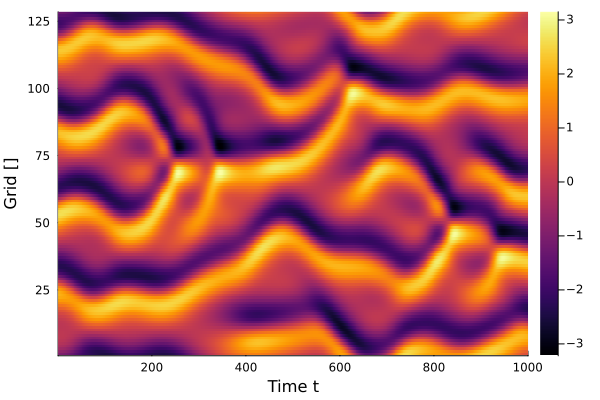

In [26]:
heatmap(Array(sol), xlabel="Time t", ylabel="Grid []")

Next, we define the neural network. For this we also introduce another kind of layer, the *Nabla layer* that is a parameterized application of a finite difference matrix. So the neural network can also learn to take a derivative or not. The parameter is penalized in the loss function so that it will likely be either $0$ or $1$:

$$\nabla(x;w) = w \cdot (\partial x)\times x + (1 - w) x$$

* With this, we can also see how to define custom layers in `Flux.jl`
    * Custom layers are `structs`
    * They are overloaded so that an instance of the `struct` can be called directly (`(nab::NablaSkipConnection{F,S})(input) where {F,S}`)
    * To make them usuable with `Flux`, one needs to call `Flux.@functor` and if not all fields of the struct are supposed to be trainable, declare which ones are with `Flux.trainable(nab::NablaSkipConnection) = (w = nab.w,)`

In [31]:
using Distributions 

"""
  NablaSkipConnection

With the input ``x``, passes ``w * (∇ * x) + (1 - |w|) * x`` , where ``w\\in\\mathbb{R}, w\\in [0,1]``. Here ``\\Nabla`` is a finite difference derivative matrix
"""
struct NablaSkipConnection{F,S}
  w::F
  one::F
  ∇::S
end

function NablaSkipConnection(∇, w::F) where F<:Number
    return NablaSkipConnection(Array([w]), Array([F(1)]), ∇)
end

NablaSkipConnection(∇, initw=()->Float32.(rand(Uniform(0.4f0,0.6f0)))) = NablaSkipConnection(∇, initw())

function (skip::NablaSkipConnection)(input)
  skip.w .* (skip.∇ * input) + (skip.one .- skip.w) .* input
end

Flux.@functor NablaSkipConnection
Optimisers.trainable(skip::NablaSkipConnection) = (w = skip.w,)

function Base.show(io::IO, b::NablaSkipConnection)
    print(io, "NablaSkipConnection with w=", b.w)
end

In [32]:
# let's define the NPDE 
nn = Chain(NablaSkipConnection(∂x), NablaSkipConnection(∂x), NablaSkipConnection(∂x), NablaSkipConnection(∂x), x->transpose(x), 
    SkipConnection(Chain(Dense(1, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, 1)),+), x->reshape(x,:)) |> gpu

p, re = Optimisers.destructure(nn)

(Float32[0.57817245, 0.5890289, 0.43840393, 0.41051912, -0.5144514, -0.66680306, 0.17010257, -0.6897938, 0.43151596, -0.009612414  …  0.09774666, -0.1340901, -0.5057036, -0.21803373, -0.14088869, -0.66862947, 0.3305283, 0.3988524, -0.44840062, 0.0], Restructure(Chain, ..., 145))

For the NPDE, we will pretend that we don't know about the second term of the equation, which we will replace with an the ANN: 

In [33]:
function node_ks(u,p,t)
    -∂x⁴*u - re(p)(u) - u.*(∂x*u)
end

node_prob = ODEProblem(node_ks, u0, (Float32(0.),Float32(dt)), p)
model = ChaoticNDE(node_prob)

nabla_penalty_func_vec(x) =  4f0 .* abs.((2f0.*((x .- 0.5f0))).^6 .- 1f0)
loss(m, x, y) = Flux.mse(m(x),y) 
loss(model, train[1], train[1][2]) 

η = 1f-3
opt = Optimisers.Adam(η)
opt_state = Optimisers.setup(opt, model) 

(p = Leaf(Adam(0.001, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), prob = (), alg = (), kwargs = ())

The training for this will take a bit (~15 minutes for some first results), here is the training loop:

In [34]:
λmax = 0.07 # maximum LE, computed beforehand with DynamicalSystems.jl
τ_max = 10
γ = 1f-5

NN_train = length(train) > 100 ? 100 : length(train)
NN_valid = length(valid) > 100 ? 100 : length(valid)
N_epochs = 2

TRAIN = false
if TRAIN 
    println("starting training...")

    for i_τ = 2:τ_max

        train_τ = NODEDataloader(train, i_τ)
        N_e = N_epochs
    
        for i_e=1:N_e 
            
            Flux.train!(model, train, opt_state) do m, t, x
                loss(m, (t,x), x) + sum(nabla_penalty_func_vec(m.p[1:4])) + γ*sum(abs.(p[5:end]))
            end
        
            if (i_e % 5) == 0
                train_error = mean([loss(model,train[i],train[i][2]) for i=1:NN_train])
                valid_error = mean([loss(model,valid[i],valid[i][2]) for i=1:NN_valid])

                println("AdamW, i_τ=", i_τ, "- training error =",train_error, "- valid error=", valid_error)
            end

            if (i_e % 5) == 0  # reduce the learning rate every 5 epochs
                η /= 2
                Optimisers.adjust!(opt_state, η)
            end
        end  
     end
end

And a demonstration of the training process:

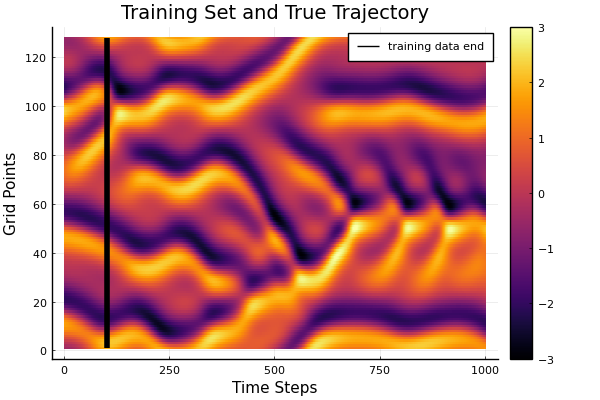

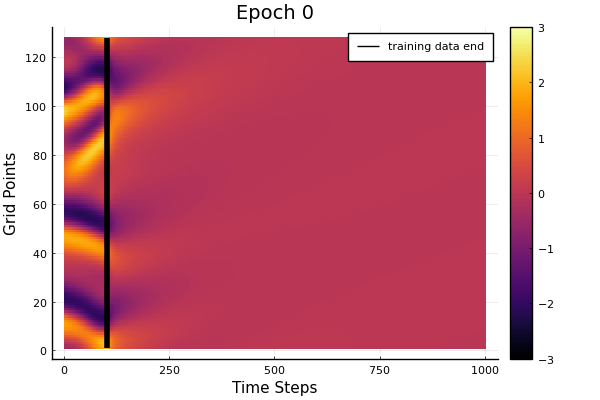

The KS equation is chaotic, so that forecast are notoriously hard to do, but hear we see a forecast length that is much longer than the training data and about $2.3 [\lambda_{max} t]$

### Additional Results 

* When further optimized and run with higher dimensional systems on GPU with more computational power, one can achieve even better results
* These are some results from the [publication](https://iopscience.iop.org/article/10.1088/1367-2630/abeb90)
* For the Kuramoto Sivashinsky equation 

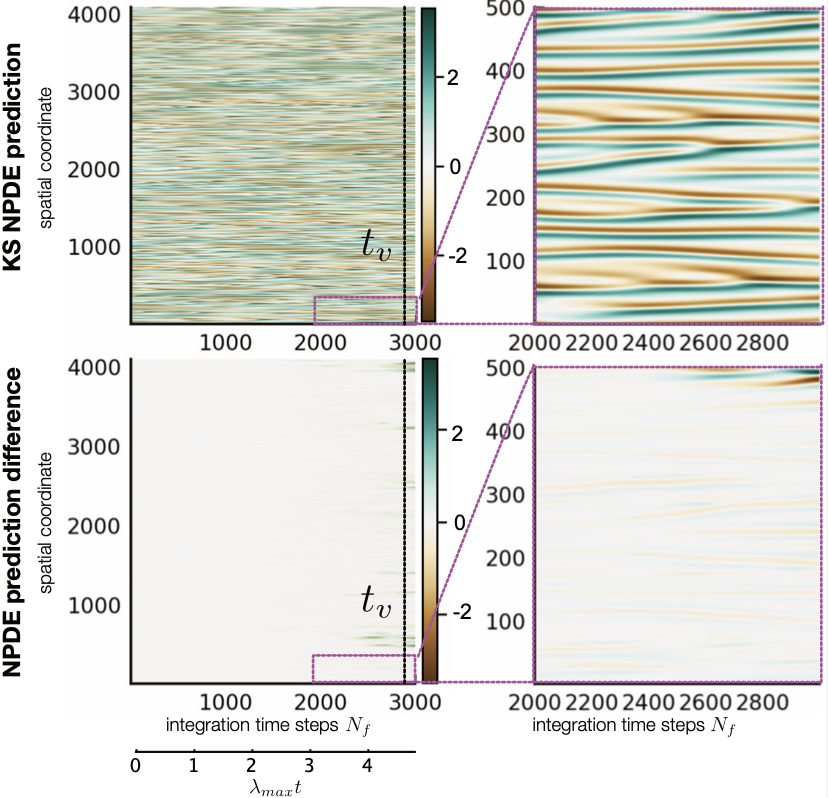

* For the Complex Ginzburg Landau equation (from exercise 9)

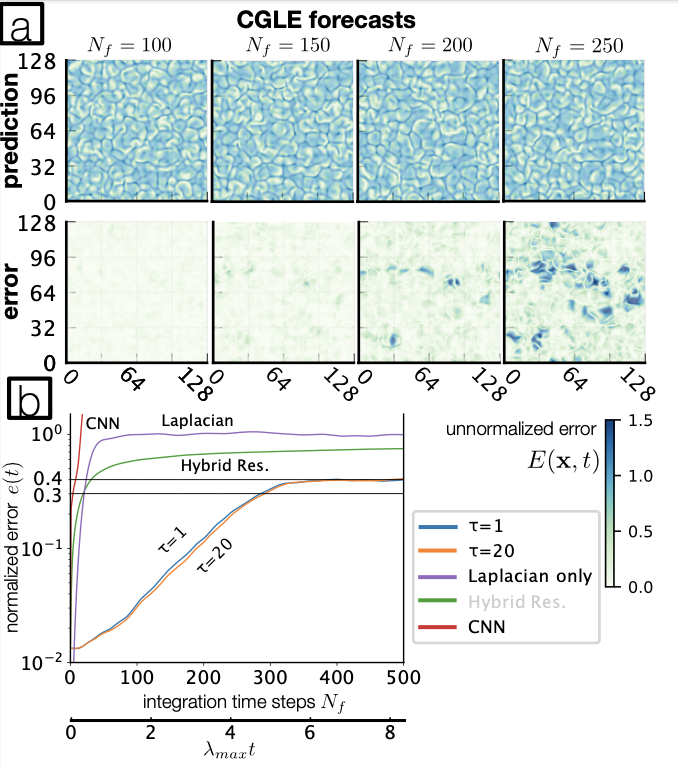

## Forecasting low-dimensional time series data 

* Can we also apply Neural ODEs to forecast e.g. a one-dimensional time series? 
* When we have an observed one dimensional time series, usually the underlying system that procded the system is higher dimensional: 
  * E.g. take the El Niño Southern Oscillation 
  * It is a chaotic time series, but we know that chaotic system need to be at least three dimensional 

![enso](assets/enso.png)

* A neural ODE in itself is not a univeral function approximator, every output needs to be the solution of a differential equation, and the solution of a 1D Neural ODE couldn't be chaotic
* But there's something easy we can do to mitigate this problem: Embedding! 
* We've seen in Lecture 5 how to do a delay-embedding of a time series to reconstruct a potentially higher-dimensional attractor
* We can apply this in these cases as well!



## Outlook: What are we doing with this for? 

* Hybrid Earth System Models 
* We have decades of research on Earth Systems Models
* But we also have massive amounts of data being recorded in real time by satelittes 
* Earth System Models still have unresolved influences, or parts of the model that either 
    * Can not be modelled accurately as they are too complex for cliamte simulations (e.g. cloud resolving models)
    * Not derived from first principles but more heuristic (e.g. vegetation models)
* So, hybrid models can fill these gaps with data-driven algorithms 
* Ongoing work for example on atmosphere models
* The challenge is that the models have to be reimplemented in e.g Julia or Python-JAX for this approach to work